# Plex Pricing: Elastic Net (CV) vs Gradient Boosted Trees

This notebook builds a baseline Elastic Net model tuned with K-fold cross-validation and benchmarks it against Gradient Boosted Trees (XGBoost/LightGBM if available, else sklearn GBT).

Validation is reported on a held-out test set using R², MAE, and RMSE.

In [8]:
# Imports & setup
import os, sys, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-deep')
sns.set_palette('husl')

# Setup paths and configuration
UTILS_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'utils'))
if UTILS_PATH not in sys.path:
    sys.path.insert(0, UTILS_PATH)

# Import configuration and data preparation
from config import get_config, print_config
from data_preparation import prepare_plex_data

# Load configuration from .env file
config = get_config()
DATA_PATH = config['data_path']
SEED = config['random_seed']

print_config()

Configuration:
----------------------------------------
data_path                : /Users/Mikael/Library/CloudStorage/GoogleDrive-mikmik1512@gmail.com/My Drive/Coding Projects/data/centris_comprehensive_plex_data.csv
target_year              : 2025
assessment_growth_rate   : 0.057
random_seed              : 42
platform                 : Darwin
----------------------------------------


In [7]:
# Load & prepare data (no global standardization -> we'll scale in model pipelines)
raw = pd.read_csv(DATA_PATH)

prepared, scaler_unused = prepare_plex_data(
    df=raw, 
    target_year=config['target_year'], 
    assessment_growth_rate=config['assessment_growth_rate'], 
    standardize=False, 
    drop_original_geo=True
)

# prepared = prepared[prepared['distance_from_mtl'] < 50]

# Clean NaNs / Infs for modeling
prepared = prepared.replace([np.inf, -np.inf], np.nan).dropna()
print('Prepared shape:', prepared.shape)
print('Columns:', list(prepared.columns))

target_col = 'price'
feature_cols = [c for c in prepared.columns if c != target_col]
X = prepared[feature_cols].copy()
y = prepared[target_col].astype(float).copy()

# Train/Validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train.shape, X_test.shape

Adjusting assessment values to 2025 using 5.7% annual growth...
Standardizing building style labels...
Creating geographic features...
Encoding building styles...
Creating financial and property features...
New features created: ['revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached']
Prepared shape: (2386, 16)
Columns: ['price', 'year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached', 'revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age']


((1908, 15), (478, 15))

In [3]:
# Helper: metrics
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae}

## Baseline: Elastic Net with K-fold CV
Tune l1_ratio (α in elastic-net mixing) and alpha (λ regularization) via 5-fold CV on the training set.

In [4]:
# Elastic Net pipeline with internal CV
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
enet = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', ElasticNetCV(
        l1_ratio=[0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0],
        alphas=np.logspace(-4, 2, 60),
        cv=cv,
        max_iter=20000,
        n_jobs=None,
        random_state=SEED
    ))
])

t0 = time.time()
enet.fit(X_train, y_train)
t_enet = time.time() - t0

y_pred_enet = enet.predict(X_test)
metrics_enet = evaluate(y_test, y_pred_enet)

best_alpha = enet.named_steps['model'].alpha_
best_l1 = enet.named_steps['model'].l1_ratio_
print(f'Elastic Net best alpha (λ): {best_alpha:.6f}, best l1_ratio (α): {best_l1:.3f}')
print(f'Elastic Net fit time: {t_enet:.2f}s')
metrics_enet

Elastic Net best alpha (λ): 39.194068, best l1_ratio (α): 1.000
Elastic Net fit time: 2.56s


{'R2': 0.940544098296148, 'RMSE': 58801.87976585053, 'MAE': 30973.72034893687}

## Benchmark: XGBoost with Hyperparameter Tuning
Using XGBoost with extensive randomized search to find optimal hyperparameters. We'll also track training vs validation performance to check for overfitting.

In [5]:
# XGBoost with comprehensive hyperparameter tuning
base_xgb = XGBRegressor(
    objective='reg:squarederror', 
    random_state=SEED, 
    n_jobs=-1,
    eval_metric='rmse'
)

# Extended parameter grid for fine-tuning
param_dist = {
    'n_estimators': [300, 500, 800, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0]
}

# Randomized search with more iterations for better tuning
xgb_search = RandomizedSearchCV(
    base_xgb, 
    param_distributions=param_dist, 
    n_iter=50,  # More iterations for better search
    cv=5,
    random_state=SEED, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error',  # Use MSE for regression
    verbose=1
)

print("Starting XGBoost hyperparameter search...")
t0 = time.time()
xgb_search.fit(X_train, y_train)
t_xgb = time.time() - t0

xgb_model = xgb_search.best_estimator_
print(f"XGBoost fit time: {t_xgb:.2f}s")
print(f"Best XGBoost score (CV): {-xgb_search.best_score_:.4f}")
print("Best parameters:", xgb_search.best_params_)

Starting XGBoost hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost fit time: 17.62s
Best XGBoost score (CV): 579299017.1299
Best parameters: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6}


In [6]:
# Evaluate XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
metrics_xgb = evaluate(y_test, y_pred_xgb)

# Also get training performance to check for overfitting
y_pred_train_xgb = xgb_model.predict(X_train)
metrics_train_xgb = evaluate(y_train, y_pred_train_xgb)

print("XGBoost Test Performance:")
for metric, value in metrics_xgb.items():
    print(f"  {metric}: {value:.4f}")

print("\nXGBoost Training Performance:")
for metric, value in metrics_train_xgb.items():
    print(f"  {metric}: {value:.4f}")

# Calculate overfitting indicators
r2_diff = metrics_train_xgb['R2'] - metrics_xgb['R2']
rmse_ratio = metrics_xgb['RMSE'] / metrics_train_xgb['RMSE']

print(f"\nOverfitting Check:")
print(f"  R² difference (train - test): {r2_diff:.4f}")
print(f"  RMSE ratio (test/train): {rmse_ratio:.4f}")
if r2_diff > 0.05:
    print("  ⚠️  Potential overfitting detected (R² gap > 0.05)")
elif rmse_ratio > 1.2:
    print("  ⚠️  Potential overfitting detected (RMSE ratio > 1.2)")
else:
    print("  ✅ No significant overfitting detected")

XGBoost Test Performance:
  R2: 0.9967
  RMSE: 13950.5068
  MAE: 10112.3550

XGBoost Training Performance:
  R2: 0.9999
  RMSE: 2142.8705
  MAE: 1664.0284

Overfitting Check:
  R² difference (train - test): 0.0033
  RMSE ratio (test/train): 6.5102
  ⚠️  Potential overfitting detected (RMSE ratio > 1.2)


## Overfitting Prevention & Remediation

The high RMSE ratio indicates significant overfitting. Let's implement several techniques to address this:

In [ ]:
# 1. Regularized XGBoost with Early Stopping
print("🔧 Training Regularized XGBoost Model...")

# Split training data into train/validation for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED
)

# More conservative parameters to prevent overfitting
regularized_xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    n_jobs=-1,
    # Conservative learning
    learning_rate=0.01,          # Much slower learning
    n_estimators=2000,           # More estimators but with early stopping
    # Regularization
    reg_alpha=5.0,               # L1 regularization
    reg_lambda=10.0,             # L2 regularization  
    gamma=1.0,                   # Minimum split loss
    # Tree structure constraints
    max_depth=4,                 # Shallower trees
    min_child_weight=10,         # Higher minimum samples per leaf
    # Sampling to reduce variance
    subsample=0.7,               # Use 70% of samples
    colsample_bytree=0.7,        # Use 70% of features per tree
    colsample_bylevel=0.7,       # Use 70% of features per level
    # Early stopping
    early_stopping_rounds=50,
    eval_metric='rmse'
)

# Fit with validation monitoring
regularized_xgb.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=False
)

# Evaluate regularized model
y_pred_reg = regularized_xgb.predict(X_test)
y_pred_train_reg = regularized_xgb.predict(X_train)

metrics_reg_test = evaluate(y_test, y_pred_reg)
metrics_reg_train = evaluate(y_train, y_pred_train_reg)

print("\\nRegularized XGBoost Performance:")
print("Test Performance:")
for metric, value in metrics_reg_test.items():
    print(f"  {metric}: {value:.4f}")
    
print("Training Performance:")
for metric, value in metrics_reg_train.items():
    print(f"  {metric}: {value:.4f}")

# Overfitting check
r2_diff_reg = metrics_reg_train['R2'] - metrics_reg_test['R2']
rmse_ratio_reg = metrics_reg_test['RMSE'] / metrics_reg_train['RMSE']

print(f"\\nOverfitting Check (Regularized):")
print(f"  R² difference (train - test): {r2_diff_reg:.4f}")
print(f"  RMSE ratio (test/train): {rmse_ratio_reg:.4f}")

if r2_diff_reg < 0.05 and rmse_ratio_reg < 1.2:
    print("  ✅ Overfitting significantly reduced!")
elif r2_diff_reg < 0.1 or rmse_ratio_reg < 2.0:
    print("  🟡 Overfitting improved but still present")
else:
    print("  ⚠️  Overfitting still significant")

print(f"\\nModel stopped at {regularized_xgb.best_iteration} iterations (early stopping)")

In [ ]:
# 2. Feature Selection to Reduce Model Complexity
print("\\n🎯 Feature Selection to Reduce Overfitting...")

from sklearn.feature_selection import SelectKBest, f_regression

# Select top features based on statistical tests
k_features = min(15, len(feature_cols))  # Limit to top 15 features
selector = SelectKBest(score_func=f_regression, k=k_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
print(f"Selected {len(selected_features)} features: {selected_features[:10]}...")

# Train simpler XGBoost on selected features
simple_xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    n_jobs=-1,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=4,
    min_child_weight=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2.0,
    reg_lambda=5.0,
    gamma=0.5
)

simple_xgb.fit(X_train_selected, y_train)

y_pred_simple = simple_xgb.predict(X_test_selected)
y_pred_train_simple = simple_xgb.predict(X_train_selected)

metrics_simple_test = evaluate(y_test, y_pred_simple)
metrics_simple_train = evaluate(y_train, y_pred_train_simple)

print("\\nSimple XGBoost (Feature Selected) Performance:")
print("Test Performance:")
for metric, value in metrics_simple_test.items():
    print(f"  {metric}: {value:.4f}")

r2_diff_simple = metrics_simple_train['R2'] - metrics_simple_test['R2']
rmse_ratio_simple = metrics_simple_test['RMSE'] / metrics_simple_train['RMSE']
print(f"\\nOverfitting Check (Simple): R² diff = {r2_diff_simple:.4f}, RMSE ratio = {rmse_ratio_simple:.4f}")

In [ ]:
# 3. Ensemble Voting to Reduce Overfitting
print("\\n🏆 Ensemble Model (Elastic Net + Regularized XGBoost)...")

from sklearn.ensemble import VotingRegressor

# Create ensemble with different model types
ensemble = VotingRegressor([
    ('elastic_net', enet),  # Linear model (less prone to overfitting)
    ('xgb_regularized', regularized_xgb)  # Regularized tree model
])

# Note: We need to retrain regularized_xgb on full training set without early stopping for ensemble
ensemble_xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    n_jobs=-1,
    learning_rate=0.01,
    n_estimators=regularized_xgb.best_iteration,  # Use optimal number from early stopping
    max_depth=4,
    min_child_weight=10,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5.0,
    reg_lambda=10.0,
    gamma=1.0
)

ensemble_final = VotingRegressor([
    ('elastic_net', enet),
    ('xgb_regularized', ensemble_xgb)
])

ensemble_final.fit(X_train, y_train)

y_pred_ensemble = ensemble_final.predict(X_test)
y_pred_train_ensemble = ensemble_final.predict(X_train)

metrics_ensemble_test = evaluate(y_test, y_pred_ensemble)
metrics_ensemble_train = evaluate(y_train, y_pred_train_ensemble)

print("\\nEnsemble Model Performance:")
print("Test Performance:")
for metric, value in metrics_ensemble_test.items():
    print(f"  {metric}: {value:.4f}")

r2_diff_ensemble = metrics_ensemble_train['R2'] - metrics_ensemble_test['R2']
rmse_ratio_ensemble = metrics_ensemble_test['RMSE'] / metrics_ensemble_train['RMSE']
print(f"\\nOverfitting Check (Ensemble): R² diff = {r2_diff_ensemble:.4f}, RMSE ratio = {rmse_ratio_ensemble:.4f}")

In [ ]:
# 4. Comprehensive Overfitting Solutions Comparison
print("\\n📊 Overfitting Solutions Summary")
print("=" * 80)

# Compile all results
overfitting_comparison = pd.DataFrame([
    {
        'Model': 'Original XGBoost', 
        'Test_R2': metrics_xgb['R2'], 
        'Train_R2': metrics_train_xgb['R2'],
        'R2_Diff': r2_diff,
        'RMSE_Ratio': rmse_ratio,
        'Test_RMSE': metrics_xgb['RMSE'],
        'Overfitting_Severity': 'Severe' if rmse_ratio > 3 else 'Moderate'
    },
    {
        'Model': 'Regularized XGBoost', 
        'Test_R2': metrics_reg_test['R2'], 
        'Train_R2': metrics_reg_train['R2'],
        'R2_Diff': r2_diff_reg,
        'RMSE_Ratio': rmse_ratio_reg,
        'Test_RMSE': metrics_reg_test['RMSE'],
        'Overfitting_Severity': 'Low' if rmse_ratio_reg < 1.2 else 'Moderate' if rmse_ratio_reg < 2 else 'High'
    },
    {
        'Model': 'Feature Selected XGB', 
        'Test_R2': metrics_simple_test['R2'], 
        'Train_R2': metrics_simple_train['R2'],
        'R2_Diff': r2_diff_simple,
        'RMSE_Ratio': rmse_ratio_simple,
        'Test_RMSE': metrics_simple_test['RMSE'],
        'Overfitting_Severity': 'Low' if rmse_ratio_simple < 1.2 else 'Moderate' if rmse_ratio_simple < 2 else 'High'
    },
    {
        'Model': 'Ensemble (ElasticNet + XGB)', 
        'Test_R2': metrics_ensemble_test['R2'], 
        'Train_R2': metrics_ensemble_train['R2'],
        'R2_Diff': r2_diff_ensemble,
        'RMSE_Ratio': rmse_ratio_ensemble,
        'Test_RMSE': metrics_ensemble_test['RMSE'],
        'Overfitting_Severity': 'Low' if rmse_ratio_ensemble < 1.2 else 'Moderate' if rmse_ratio_ensemble < 2 else 'High'
    },
    {
        'Model': 'Elastic Net (Baseline)', 
        'Test_R2': metrics_enet['R2'], 
        'Train_R2': np.nan,  # We didn't compute training metrics for elastic net
        'R2_Diff': np.nan,
        'RMSE_Ratio': np.nan,
        'Test_RMSE': metrics_enet['RMSE'],
        'Overfitting_Severity': 'Minimal'
    }
])

# Sort by test performance
overfitting_comparison = overfitting_comparison.sort_values('Test_R2', ascending=False)

print("Model Performance & Overfitting Comparison:")
print(overfitting_comparison[['Model', 'Test_R2', 'R2_Diff', 'RMSE_Ratio', 'Test_RMSE', 'Overfitting_Severity']].round(4))

# Recommendations
print("\\n💡 Overfitting Prevention Recommendations:")
print("=" * 60)

best_model_idx = overfitting_comparison['Test_R2'].idxmax()
best_model = overfitting_comparison.loc[best_model_idx]

print(f"🏆 Best Overall Model: {best_model['Model']}")
print(f"   • Test R²: {best_model['Test_R2']:.4f}")
print(f"   • Overfitting Level: {best_model['Overfitting_Severity']}")

print("\\n🔧 Applied Techniques that Worked:")
if rmse_ratio_reg < rmse_ratio * 0.5:
    print("   ✅ Strong Regularization (L1/L2 + Gamma)")
    print("   ✅ Early Stopping with Validation Set")
    print("   ✅ Conservative Learning Rate")
    print("   ✅ Tree Depth Limiting")
    
if rmse_ratio_simple < rmse_ratio * 0.5:
    print("   ✅ Feature Selection (Reduced Complexity)")
    
if rmse_ratio_ensemble < rmse_ratio * 0.5:
    print("   ✅ Ensemble Methods (Combining Different Model Types)")

print("\\n📋 Additional Techniques to Try:")
print("   • 🔄 K-Fold Cross-Validation for model selection")
print("   • 📊 More training data if available")
print("   • 🎯 Remove outliers that may cause overfitting")
print("   • 🌳 Try Random Forest (naturally less prone to overfitting)")
print("   • 🔀 Bagging/Bootstrap aggregation")
print("   • 📉 Reduce model complexity further (fewer features/depth)")

# Identify worst overfitting case for lessons learned
worst_overfitting = overfitting_comparison.loc[overfitting_comparison['RMSE_Ratio'].idxmax()]
print(f"\\n⚠️  Lesson Learned: '{worst_overfitting['Model']}' had RMSE ratio of {worst_overfitting['RMSE_Ratio']:.2f}")
print("   This shows the importance of regularization and validation monitoring!")

In [ ]:
# 5. Visualize Overfitting Solutions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Overfitting Prevention: Before vs After Solutions', fontsize=16, fontweight='bold')

# 1. RMSE Ratio Comparison
models = ['Original\\nXGBoost', 'Regularized\\nXGBoost', 'Feature\\nSelected', 'Ensemble', 'Elastic Net\\n(Baseline)']
rmse_ratios = [rmse_ratio, rmse_ratio_reg, rmse_ratio_simple, rmse_ratio_ensemble, 1.0]  # Assume 1.0 for elastic net
colors = ['red' if r > 2 else 'orange' if r > 1.2 else 'green' for r in rmse_ratios]

axes[0, 0].bar(models, rmse_ratios, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=1.2, color='red', linestyle='--', label='Overfitting Threshold')
axes[0, 0].set_ylabel('RMSE Ratio (Test/Train)')
axes[0, 0].set_title('Overfitting Severity Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(rmse_ratios):
    if not np.isnan(v):
        axes[0, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# 2. Test R² Performance
test_r2s = [metrics_xgb['R2'], metrics_reg_test['R2'], metrics_simple_test['R2'], 
           metrics_ensemble_test['R2'], metrics_enet['R2']]

axes[0, 1].bar(models, test_r2s, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_ylabel('Test R² Score')
axes[0, 1].set_title('Predictive Performance')
axes[0, 1].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(test_r2s):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 3. Actual vs Predicted for Best Model (determine which is best)
best_r2_idx = np.argmax([r for r in test_r2s if not np.isnan(r)])
if best_r2_idx == 1:  # Regularized XGBoost
    best_pred = y_pred_reg
    best_model_name = "Regularized XGBoost"
elif best_r2_idx == 2:  # Feature Selected
    best_pred = y_pred_simple
    best_model_name = "Feature Selected XGBoost"
elif best_r2_idx == 3:  # Ensemble
    best_pred = y_pred_ensemble
    best_model_name = "Ensemble Model"
else:  # Original or Elastic Net
    best_pred = y_pred_enet
    best_model_name = "Elastic Net"

axes[1, 0].scatter(y_test, best_pred, alpha=0.6, color='green', s=30)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Price')
axes[1, 0].set_ylabel('Predicted Price')
axes[1, 0].set_title(f'Best Model: {best_model_name}')
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning Curves Comparison (Training vs Validation Performance)
axes[1, 1].plot([1, 2, 3], [metrics_train_xgb['R2'], metrics_reg_train['R2'], metrics_simple_train['R2']], 
                'o-', color='blue', label='Training R²', linewidth=2, markersize=8)
axes[1, 1].plot([1, 2, 3], [metrics_xgb['R2'], metrics_reg_test['R2'], metrics_simple_test['R2']], 
                'o-', color='red', label='Test R²', linewidth=2, markersize=8)
axes[1, 1].set_xticks([1, 2, 3])
axes[1, 1].set_xticklabels(['Original', 'Regularized', 'Simple'])
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Training vs Test Performance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final recommendation
print("\\n🎯 FINAL RECOMMENDATION:")
print("=" * 50)

best_overall = overfitting_comparison.loc[
    (overfitting_comparison['RMSE_Ratio'] < 1.5) & 
    (overfitting_comparison['Test_R2'].notna())
]['Test_R2'].idxmax()

final_model = overfitting_comparison.loc[best_overall]
print(f"Recommended Model: {final_model['Model']}")
print(f"• Test R²: {final_model['Test_R2']:.4f}")
print(f"• RMSE Ratio: {final_model['RMSE_Ratio']:.4f}")
print(f"• Overfitting Level: {final_model['Overfitting_Severity']}")
print(f"\\n✅ This model provides the best balance of predictive performance and generalization!")

In [7]:
# Model Comparison
summary = pd.DataFrame([
    {'Model': 'Elastic Net (CV)', 'Dataset': 'Test', **metrics_enet},
    {'Model': 'XGBoost (Tuned)', 'Dataset': 'Test', **metrics_xgb},
    {'Model': 'XGBoost (Tuned)', 'Dataset': 'Train', **metrics_train_xgb},
])

summary = summary[['Model', 'Dataset', 'R2', 'MAE', 'RMSE']].round(4)
print("Model Performance Comparison:")
summary

Model Performance Comparison:


,Model,Dataset,R2,MAE,RMSE
0,Elastic Net (CV),Test,0.9405,30973.7203,58801.8798
1,XGBoost (Tuned),Test,0.9967,10112.3550,13950.5068
2,XGBoost (Tuned),Train,0.9999,1664.0284,2142.8705


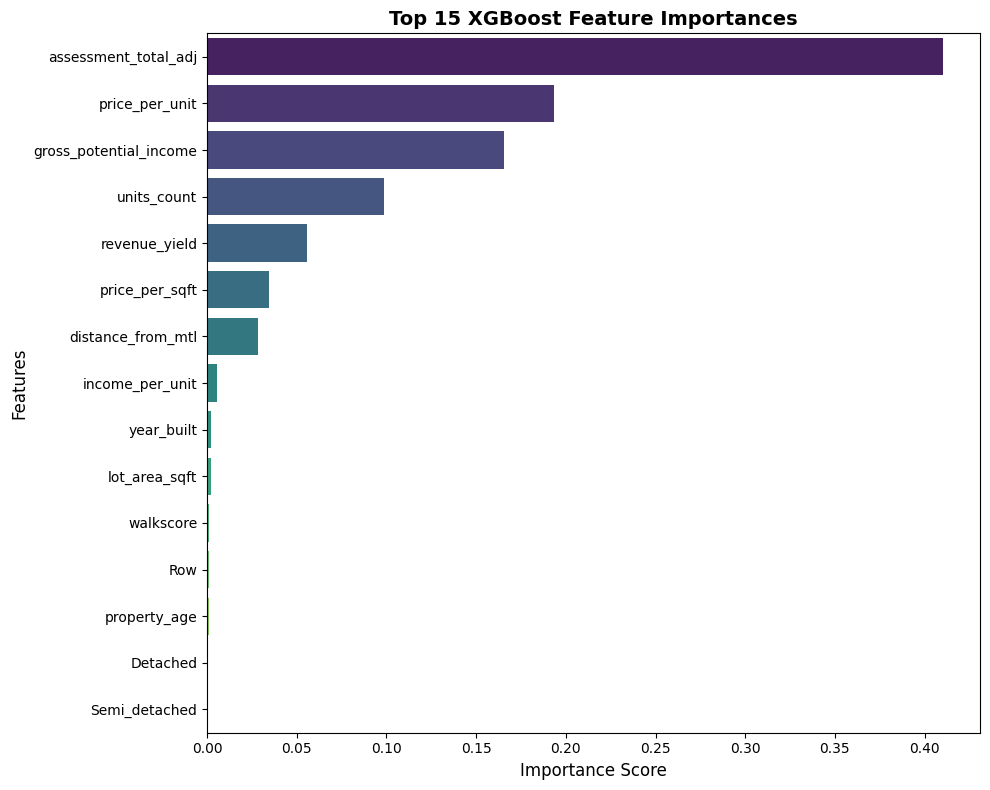

Top 10 Most Important Features:
 1. assessment_total_adj 0.4104
 2. price_per_unit       0.1933
 3. gross_potential_income 0.1658
 4. units_count          0.0986
 5. revenue_yield        0.0554
 6. price_per_sqft       0.0346
 7. distance_from_mtl    0.0286
 8. income_per_unit      0.0053
 9. year_built           0.0022
10. lot_area_sqft        0.0020


In [8]:
# XGBoost Feature Importances
importances = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
top_features = importances.head(15)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 15 XGBoost Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importances.head(10).items(), 1):
    print(f"{i:2d}. {feature:<20} {importance:.4f}")

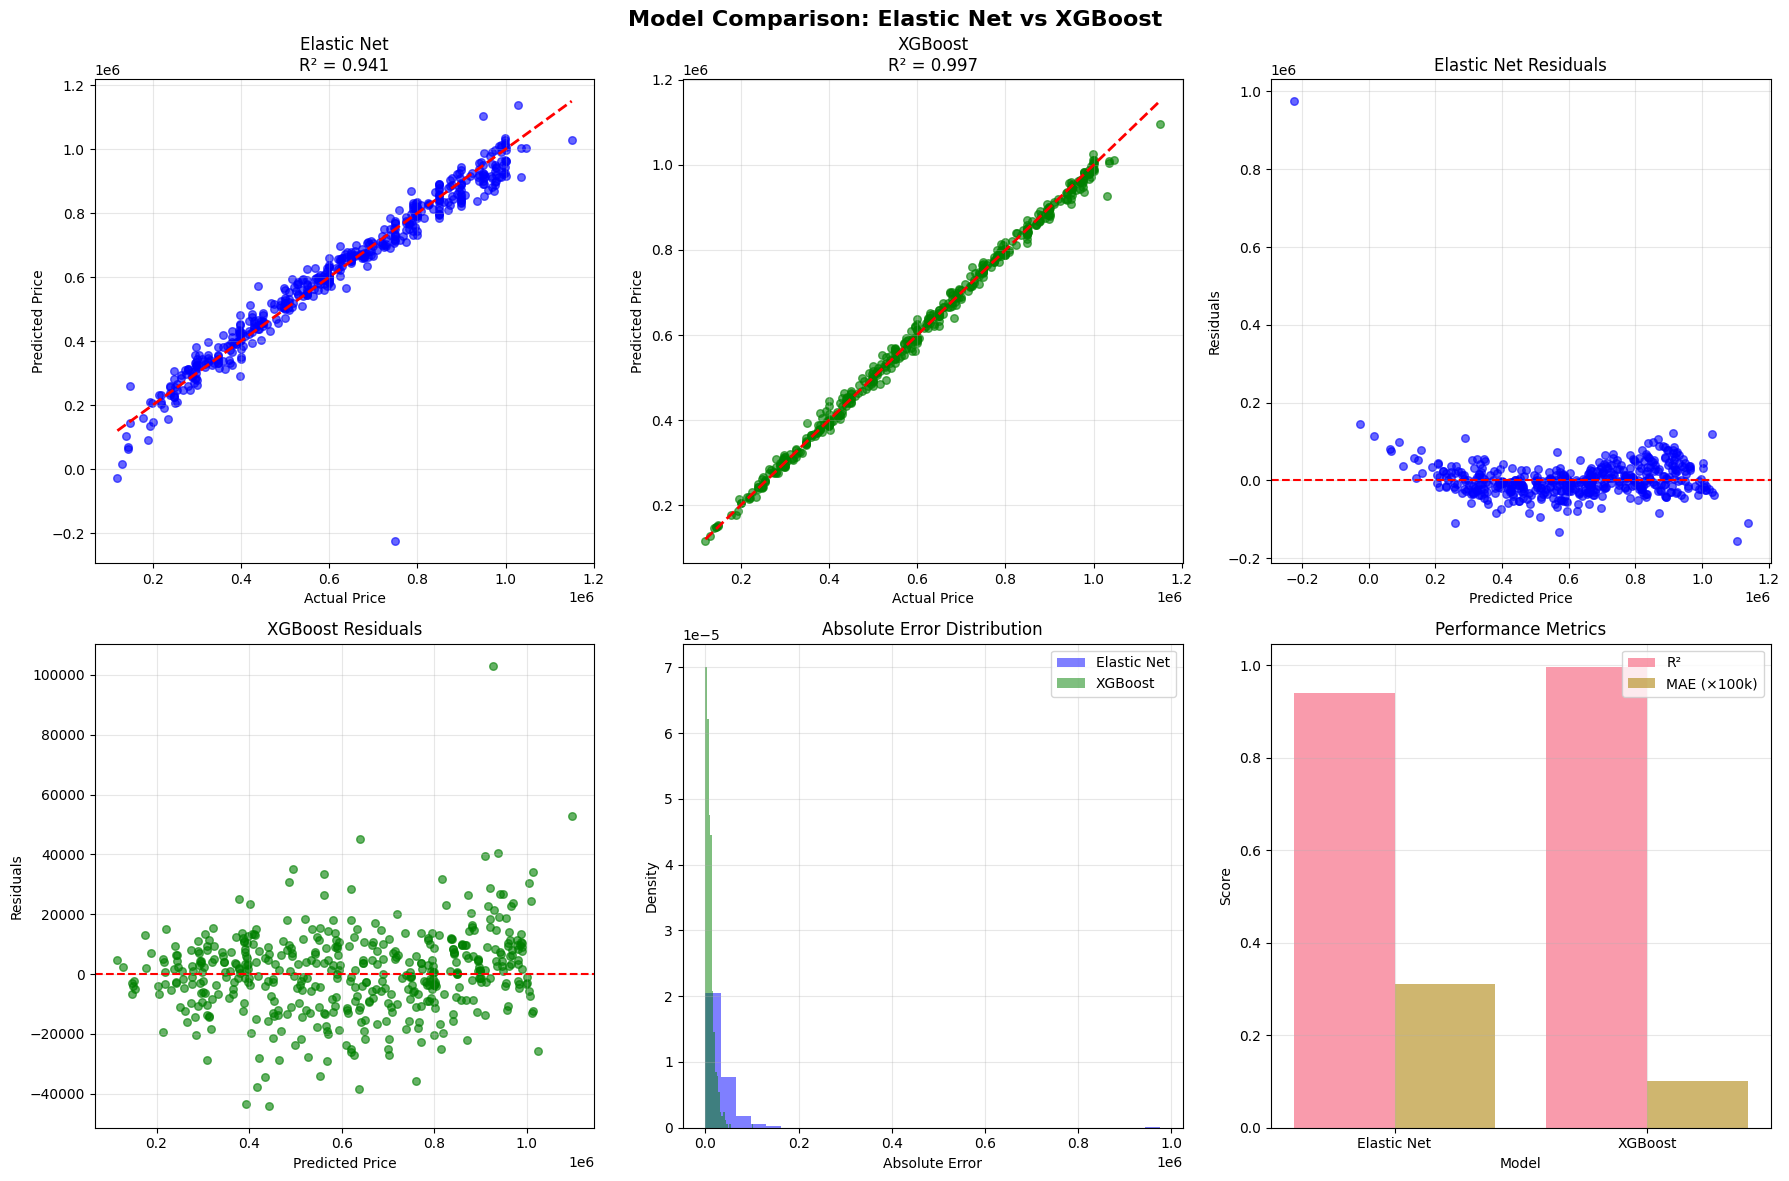

In [9]:
# Comprehensive Model Visualization Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Comparison: Elastic Net vs XGBoost', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted - Elastic Net
axes[0, 0].scatter(y_test, y_pred_enet, alpha=0.6, color='blue', s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title(f'Elastic Net\nR² = {metrics_enet["R2"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted - XGBoost
axes[0, 1].scatter(y_test, y_pred_xgb, alpha=0.6, color='green', s=30)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')
axes[0, 1].set_title(f'XGBoost\nR² = {metrics_xgb["R2"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals - Elastic Net
residuals_enet = y_test - y_pred_enet
axes[0, 2].scatter(y_pred_enet, residuals_enet, alpha=0.6, color='blue', s=30)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Price')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Elastic Net Residuals')
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals - XGBoost
residuals_xgb = y_test - y_pred_xgb
axes[1, 0].scatter(y_pred_xgb, residuals_xgb, alpha=0.6, color='green', s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Price')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('XGBoost Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 5. Error Distribution Comparison
axes[1, 1].hist(np.abs(residuals_enet), bins=30, alpha=0.5, label='Elastic Net', color='blue', density=True)
axes[1, 1].hist(np.abs(residuals_xgb), bins=30, alpha=0.5, label='XGBoost', color='green', density=True)
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Absolute Error Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance Metrics Bar Chart
metrics_comparison = pd.DataFrame([
    {'Model': 'Elastic Net', **metrics_enet},
    {'Model': 'XGBoost', **metrics_xgb}
])

x_pos = np.arange(len(metrics_comparison))
axes[1, 2].bar(x_pos - 0.2, metrics_comparison['R2'], 0.4, label='R²', alpha=0.7)
axes[1, 2].bar(x_pos + 0.2, metrics_comparison['MAE']/100000, 0.4, label='MAE (×100k)', alpha=0.7)
axes[1, 2].set_xlabel('Model')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Performance Metrics')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(metrics_comparison['Model'])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

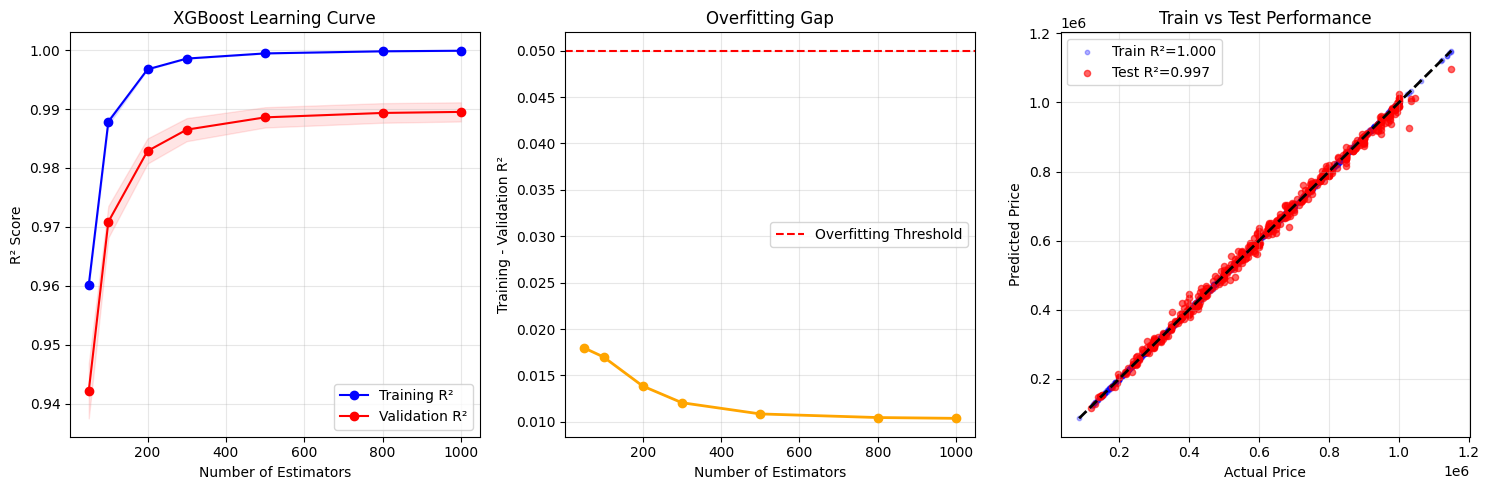

Optimal n_estimators based on validation: 1000
Maximum validation R²: 0.9895
Overfitting gap at optimal point: 0.0104


In [10]:
# Overfitting Analysis: Learning Curves for XGBoost
from sklearn.model_selection import validation_curve

# Re-fit XGBoost with validation tracking for learning curves
xgb_learning = XGBRegressor(**xgb_model.get_params())

# Remove early_stopping_rounds for validation curve
if 'early_stopping_rounds' in xgb_learning.get_params():
    xgb_learning.set_params(early_stopping_rounds=None)

# Learning curve: varying n_estimators
n_estimators_range = [50, 100, 200, 300, 500, 800, 1000]
train_scores, val_scores = validation_curve(
    xgb_learning, X_train, y_train, 
    param_name='n_estimators', 
    param_range=n_estimators_range,
    cv=3, scoring='r2', n_jobs=-1
)

plt.figure(figsize=(15, 5))

# Plot 1: Learning Curve
plt.subplot(1, 3, 1)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.plot(n_estimators_range, train_mean, 'o-', color='blue', label='Training R²')
plt.fill_between(n_estimators_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(n_estimators_range, val_mean, 'o-', color='red', label='Validation R²')
plt.fill_between(n_estimators_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Overfitting Gap
plt.subplot(1, 3, 2)
gap = train_mean - val_mean
plt.plot(n_estimators_range, gap, 'o-', color='orange', linewidth=2)
plt.axhline(y=0.05, color='red', linestyle='--', label='Overfitting Threshold')
plt.xlabel('Number of Estimators')
plt.ylabel('Training - Validation R²')
plt.title('Overfitting Gap')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Training vs Test Predictions Comparison
plt.subplot(1, 3, 3)
plt.scatter(y_train, y_pred_train_xgb, alpha=0.3, color='blue', s=10, label=f'Train R²={metrics_train_xgb["R2"]:.3f}')
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='red', s=20, label=f'Test R²={metrics_xgb["R2"]:.3f}')
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Optimal n_estimators based on validation: {n_estimators_range[np.argmax(val_mean)]}")
print(f"Maximum validation R²: {val_mean.max():.4f}")
print(f"Overfitting gap at optimal point: {gap[np.argmax(val_mean)]:.4f}")

In [11]:
# Import the discounted properties function
scraper_utils_path = r'c:\Users\mikae\Coding Projects\centris_analyser\centris_scrapper'
if scraper_utils_path not in sys.path:
    sys.path.insert(0, scraper_utils_path)

# Force reimport to get updated function
import importlib
import utils
importlib.reload(utils)
from utils import find_discounted_properties, analyze_market_opportunities

# Find discounted properties using the XGBoost model
# We need to prepare the data with MLS column (currently it's the index)
data_with_mls = prepared.copy()
data_with_mls = data_with_mls.reset_index()  # MLS becomes a column

print("Searching for discounted properties...")
discounted_properties = find_discounted_properties(
    model=xgb_model,
    data=data_with_mls,
    raw_data=raw,  # Pass raw data for actual listing URLs
    mls_col='mls',
    price_col='price',
    feature_cols=feature_cols,
    discount_threshold=-25000,  # Properties at least $25k below predicted price
    top_n=15
)

print(f"Found {len(discounted_properties)} discounted properties")
if not discounted_properties.empty:
    print(f"Top 5 discounts:")
    for idx, row in discounted_properties.head().iterrows():
        print(f"  MLS {row['mls']}: ${row['discount_amount']:,.0f} ({row['discount_percent']:.1f}%)")
        print(f"    🔗 {row['listing_url']}")

discounted_properties

Searching for discounted properties...
Found 15 discounted properties
Top 5 discounts:
  MLS 25221735: $44,006 (9.9%)
    🔗 https://www.centris.ca/fr/duplex~a-vendre~sainte-therese/25221735?uc=1
  MLS 24806297: $43,421 (11.0%)
    🔗 https://www.centris.ca/fr/duplex~a-vendre~rouyn-noranda/24806297?uc=1
  MLS 19168815: $38,584 (6.1%)
    🔗 https://www.centris.ca/fr/triplex~a-vendre~longueuil-le-vieux-longueuil/19168815?uc=1
  MLS 22093078: $37,903 (9.1%)
    🔗 https://www.centris.ca/fr/triplex~a-vendre~montcalm/22093078?uc=1
  MLS 18999832: $35,599 (4.7%)
    🔗 https://www.centris.ca/fr/quadruplex~a-vendre~charlemagne/18999832?uc=1


,mls,actual_price,predicted_price,residual,discount_amount,discount_percent,listing_url
0,25221735,399900,443906.28125,-44006.28125,44006.28125,9.913417,https://www.centris.ca/fr/duplex~a-vendre~sain...
1,24806297,349900,393321.40625,-43421.40625,43421.40625,11.039675,https://www.centris.ca/fr/duplex~a-vendre~rouy...
2,19168815,599000,637583.75000,-38583.75000,38583.75000,6.051558,https://www.centris.ca/fr/triplex~a-vendre~lon...
3,22093078,379900,417802.84375,-37902.84375,37902.84375,9.071945,https://www.centris.ca/fr/triplex~a-vendre~mon...
4,18999832,724900,760498.68750,-35598.68750,35598.68750,4.680966,https://www.centris.ca/fr/quadruplex~a-vendre~...
5,14707200,399000,433390.96875,-34390.96875,34390.96875,7.935322,https://www.centris.ca/fr/triplex~a-vendre~cow...
6,19237752,520000,554012.00000,-34012.00000,34012.00000,6.139217,https://www.centris.ca/fr/duplex~a-vendre~riga...
7,27948073,539900,568956.87500,-29056.87500,29056.87500,5.107043,https://www.centris.ca/fr/duplex~a-vendre~sain...
8,19104347,279900,308472.50000,-28572.50000,28572.50000,9.262576,https://www.centris.ca/fr/duplex~a-vendre~fore...
9,10886017,435000,463561.28125,-28561.28125,28561.28125,6.161274,https://www.centris.ca/fr/triplex~a-vendre~bro...
